In [1]:
#import scrublet as scr
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
from scipy.stats import binom
from scipy.stats import multinomial
import seaborn as sns
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings('ignore')
import matplotlib.patches as mpatches

import scrublet as scr
import harmonypy as hm
import pickle
from random import sample
from matplotlib_venn import venn2

In [2]:
#SG_DF = pd.read_pickle('./Focused_SG_DF.pkl')

In [3]:
#CM_Cells = sc.read_h5ad('./Validation_CM_DF.h5ad')

In [4]:
PATH = '../../Data/Pickles/'
Dict_File = open(PATH + "Guide_Dictionary_Filtered.pkl", "rb")
CM_FILTERED_DICT = pickle.load(Dict_File)

### Process sgRNA

In [5]:
cell_list = []
for cell in SG_DF.index:
    if cell in CM_Cells.obs.index:
        cell_list.append(cell)
SG_DF = SG_DF.loc[cell_list]

In [6]:
### Make Dict of sgRNA 
SG_Targets = []
for sg in SG_DF.columns:
    SG_Targets.append(sg.split('_')[0])
SG_Targets = np.unique(SG_Targets)

SG_Name = []
SG_Indi = []
for sg in SG_Targets:
    if sg == 'NC_Blank':
        SG_Name.append('NC')
        SG_Indi.append('NC_Blank')
    else:
        SG_Name.append(sg)
        sg_list = []
        for indi in SG_DF.columns:
            if indi.split('_')[0] == sg:
                sg_list.append(indi)
        SG_Indi.append(sg_list)
Guide_Dictionary = dict(zip(SG_Name, SG_Indi))

In [7]:
### Cells for each sgRNA
Cell_List = []
for target in SG_DF.columns:
    Cell_Subset = []
    if target == 'NC_Blank':
        for cell in SG_DF.index:
            if sum(SG_DF.loc[cell] >0) != 1:
                continue
            if SG_DF.loc[cell][target] >0:
                Cell_Subset.append(cell)
    else:
        [Cell_Subset.append(i) for i in SG_DF[SG_DF[target] > 0].index]
    Cell_List.append(Cell_Subset)
SG_Dictionary = dict(zip(SG_DF.columns, Cell_List))

In [8]:
### List of perturbed cells
Perturbed_Cells = []
for target in Guide_Dictionary.keys():
    if target == 'NC':
        continue
        
    Filtered_SG = [i for i in Guide_Dictionary[target] if int(i.split('_')[1]) not in CM_FILTERED_DICT[target]]
    for i in Filtered_SG:
        Perturbed_Cells.extend(SG_Dictionary[i])
    
Perturbed_Cells = np.unique(Perturbed_Cells)

In [9]:
sg_id = []
for cell in CM_Cells.obs.index:
    if cell in SG_Dictionary['NC_Blank']:
        sg_id.append('NC')
    elif cell in Perturbed_Cells:
        sg_id.append('TBX5_ENH')
    else:
        sg_id.append('Other')
CM_Cells.obs['sg_id'] = sg_id

In [10]:
CM_Cells_Perturbed = CM_Cells[CM_Cells.obs.sg_id != 'Other']

### SG Distribution

In [11]:
#### NC Cells
sg_pos_cell_NC = []
for bc in CM_Cells_Perturbed.obs.index:
    if bc in CM_Cells_Perturbed[CM_Cells_Perturbed.obs['sg_id'] == 'NC'].obs.index:
        sg_pos_cell_NC.append(1)
    else:
        sg_pos_cell_NC.append(0)

In [12]:
#### All Pertubation Cells
sg_pos_cell = []
for bc in CM_Cells_Perturbed.obs.index:
    if bc in CM_Cells_Perturbed[CM_Cells_Perturbed.obs['sg_id'] == 'TBX5_ENH'].obs.index:
        sg_pos_cell.append(1)
    else:
        sg_pos_cell.append(0)

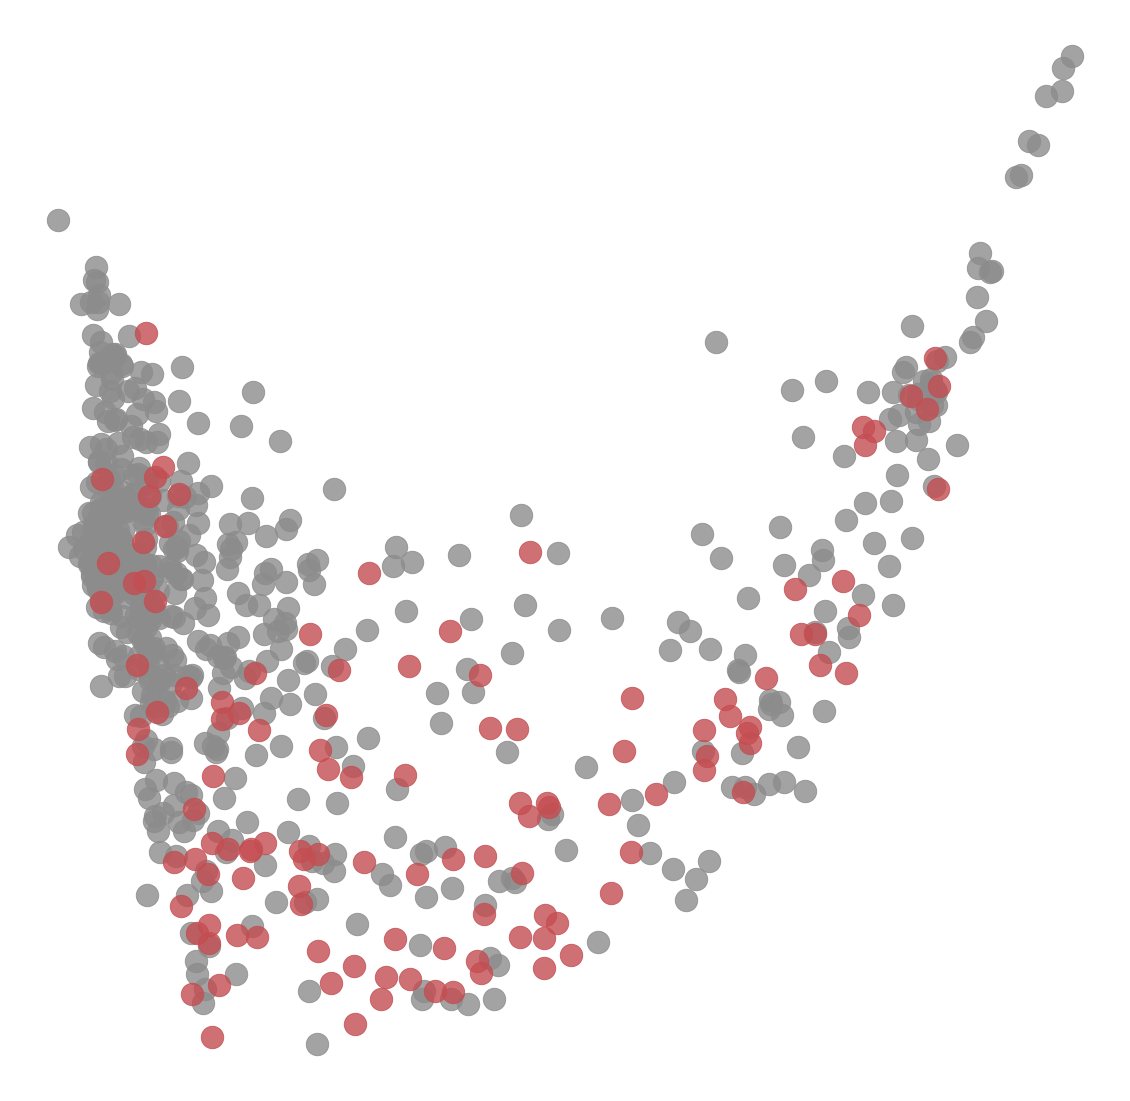

In [13]:
fig, ax = plt.subplots(figsize=(20,20))


indices = np.nonzero(sg_pos_cell_NC)[0]
x = CM_Cells_Perturbed.obsm['X_phate'][indices,0]
y = CM_Cells_Perturbed.obsm['X_phate'][indices,1]
ax.scatter(x, 
           y, 
           c='#8c8c8c',
           s=500,
        alpha=0.8)

indices = np.nonzero(sg_pos_cell)[0]
x = CM_Cells_Perturbed.obsm['X_phate'][indices,0]
y = CM_Cells_Perturbed.obsm['X_phate'][indices,1]
ax.scatter(x, 
           y, 
           c='#c44e52',
           s=500,
        alpha=0.8)
ax.set_xticklabels([])
ax.set_yticklabels([])



plt.axis('off')
#ax.legend(['Undetected', 'NC', 'TBX5 Enhancer sgRNA'])
ax.grid(False)



#ax.set_title(str(query_region) + '___Cells:' + str(sum(sg_pos_cell)))
plt.savefig('./CM_PHATE_SG_Clustering.png')